# NYPD Motor Vehicle Collision Exploratory Analysis
____
Micaela Flores (mrf444), Laureano Nisenbaum (lvn218), Jason Li (yl2813), Trevor Mitchell (tim225)

### Cleaning the Data: Cleaning from Raw Data and Regrouping Accident Causes (Micaela)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.preprocessing import LabelEncoder

def cleanData(filename,startdate,enddate):
    df = pd.read_csv(filename)
    
    #convert date column to datetime objects
    df["DATE"] = pd.to_datetime(df["DATE"]) #takes a bit to run 
    
    start, end = pd.to_datetime([startdate,enddate],format='%d%b%Y')
    
    #filter out only dates starting from start date and ending with end date
    df = df[(df["DATE"] >= start) & (df["DATE"] <= end)]
    
    #drop all rows that contain NaN in the Borough and Zip Code column 
    df = df.dropna(subset=["BOROUGH","ZIP CODE"])
    
    #change Time column to datetime objects
    df['TIME'] = pd.to_datetime(df['TIME'],format= '%H:%M' ).dt.time
    
    #change Zip Code column to integers
    df['ZIP CODE'] = df['ZIP CODE'].astype('int64')
    
    #only get relevant columns
    df = df.drop(["LOCATION","ON STREET NAME","CROSS STREET NAME",\
         "OFF STREET NAME","CONTRIBUTING FACTOR VEHICLE 3","CONTRIBUTING FACTOR VEHICLE 4",\
         "CONTRIBUTING FACTOR VEHICLE 5","UNIQUE KEY","VEHICLE TYPE CODE 1",
         "VEHICLE TYPE CODE 2","VEHICLE TYPE CODE 3","VEHICLE TYPE CODE 4","VEHICLE TYPE CODE 5"],axis=1)
    df = df.loc[df["CONTRIBUTING FACTOR VEHICLE 1"] != "Unspecified"] #"LATITUDE","LONGITUDE"
    
    #encode the string accident causes into categorical numbers for later grouping
    le = LabelEncoder()
    df.insert(13,'REASON',le.fit_transform(df['CONTRIBUTING FACTOR VEHICLE 1'].astype(str)))
    map_key = dict(zip(le.classes_, le.transform(le.classes_))) #for our purposes to know how numbers match up
    
    reason_map = {9:'Distracted Driving',33:'Distracted Driving',14:'Distracted Driving',6:'Distracted Driving',\
              7:'Distracted Driving',8:'Distracted Driving',28:'Distracted Driving',25:'Distracted Driving',\
              54:'Distracted Driving',45:'Distracted Driving',18:'Impaired Driving',2:'Impaired Driving',\
              22:'Impaired Driving',23:'Impaired Driving',17:'Impaired Driving',26:'Impaired Driving',\
              39:'Impaired Driving',12:'Impaired Driving',13:'Impaired Driving',40:'Impaired Driving',\
              4:'Bad Driving',52:'Bad Driving',34:'Bad Driving',16:'Bad Driving', 19:'Bad Driving', \
              35:'Bad Driving',53:'Bad Driving',51:'Bad Driving',10:'Bad Driving',1:'Bad Driving',\
              50:'Bad Driving',15:'Bad Driving', 56:'Poor Driving Conditions',20:'Poor Driving Conditions',\
              27:'Poor Driving Conditions',37:'Poor Driving Conditions',24:'Unsafe Infrastructure',\
              36:'Unsafe Infrastructure',49:'Unsafe Infrastructure',29:'Unsafe Infrastructure',\
              43:'Unsafe Infrastructure', 30:'External Factor', 38:'External Factor',3:'External Factor',\
              31:'External Factor',41:'External Factor',42:'External Factor',47:'Mechanical Failure',\
              5:'Mechanical Failure',44:'Mechanical Failure',0:'Mechanical Failure',21:'Mechanical Failure',\
              48:'Mechanical Failure',57:'Mechanical Failure',32:'Other',55:'Other',46:'Other',11:'Other',58:'Other'}
    
    #group into our designated categories
    df['REASON'] = df['REASON'].map(reason_map)
    
    return df

In [2]:
df = cleanData("NYPD_Motor_Vehicle_Collisions.csv","1NOV2017","31OCT2018")
#print("Size of data after cleaning: ",df.shape)
#df.head(5)

/Users/JasonLi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Import Zipcode Shape file (Jason)

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
def cleanDataZipCode(filename):
    Zipcode_shape = gpd.read_file(filename)
    Zipcode_shape = Zipcode_shape.drop(['BLDGZIP','STATE','ST_FIPS','CTY_FIPS','URL','SHAPE_AREA','SHAPE_LEN',\
                                    'AREA','PO_NAME'],axis=1)
    Zipcode_shape["ZIPCODE"] = Zipcode_shape["ZIPCODE"].astype(str).astype(int)
    return Zipcode_shape

In [6]:
df_zipcode = cleanDataZipCode("ZIP_CODE_040114/ZIP_CODE_040114.shp")
df_zipcode.head(5)

ZIPCODE  POPULATION  COUNTY  \
0    11436     18681.0  Queens   
1    11213     62426.0   Kings   
2    11212     83866.0   Kings   
3    11225     56527.0   Kings   
4    11218     72280.0   Kings   

                                            geometry  
0  POLYGON ((1038098.251871482 188138.3800067157,...  
1  POLYGON ((1001613.712964058 186926.4395172149,...  
2  POLYGON ((1011174.275535807 183696.33770971, 1...  
3  POLYGON ((995908.3654508889 183617.6128015518,...  
4  POLYGON ((991997.1134308875 176307.4958601296,...

In [7]:
#Create new csv files instead of cleaning data everytime
#df.to_csv('cleaned_df.csv')
df = pd.read_csv('cleaned_df.csv').drop(['Unnamed: 0'], axis=1)

In [8]:
## Return a Dataframe for each Borough
#def Merge_twoDFbyZC(df_zipcode,main_df):
#    result = df_zipcode.merge(df, left_on='ZIPCODE', right_on='ZIP CODE', how='inner').drop(['ZIP CODE'],axis = 1)
#    return result
#new_df = Merge_twoDFbyZC(df_zipcode,df)

### HEATMAP (Group by Zipcode and Borough) (Jason)

In [9]:
def groupby_all(borough_df,df):
    temp_df = df.groupby(['ZIP CODE','BOROUGH','REASON']).size().unstack(2).reset_index().fillna(0)
    temp_df.columns.name = ''
    result = borough_df.merge(temp_df, left_on='ZIPCODE', right_on='ZIP CODE', how='inner').drop('ZIP CODE', axis = 1)
    return result

In [10]:
df_groupall = groupby_all(df_zipcode,df)

In [11]:
df_groupall[['Bad Driving Per Cap','Distracted Driving Per Cap', 'External Factor Per Cap',\
             'Poor Driving Conditions Per Cap','Unsafe Infrastructure Per Cap','Mechanical Failure Per Cap'\
             ,'Other Per Cap','Impaired Driving Per Cap']] \
= df_groupall[['Bad Driving','Distracted Driving','External Factor','Poor Driving Conditions'\
               ,'Unsafe Infrastructure','Mechanical Failure','Other','Impaired Driving']\
             ].div(df_groupall['POPULATION'].values,axis=0)

In [12]:
Brooklyn = df_groupall[df_groupall['BOROUGH'] == 'BROOKLYN']
Bronx = df_groupall[df_groupall['BOROUGH'] == 'BRONX']
Manhattan = df_groupall[df_groupall['BOROUGH'] == 'MANHATTAN']
#No one lives in Central Park
Manhattan = Manhattan[Manhattan['POPULATION'] != 0]
Queens = df_groupall[df_groupall['BOROUGH'] == 'QUEENS']
Queens = Queens[Queens['POPULATION'] != 0]
Staten_Island = df_groupall[df_groupall['BOROUGH'] == 'STATEN ISLAND']

In [13]:
Queens.loc[Queens['ZIPCODE'] == 11430, ~Queens.\
           columns.isin(['ZIPCODE', 'POPULATION', 'COUNTY', 'geometry','BOROUGH'])] = 0

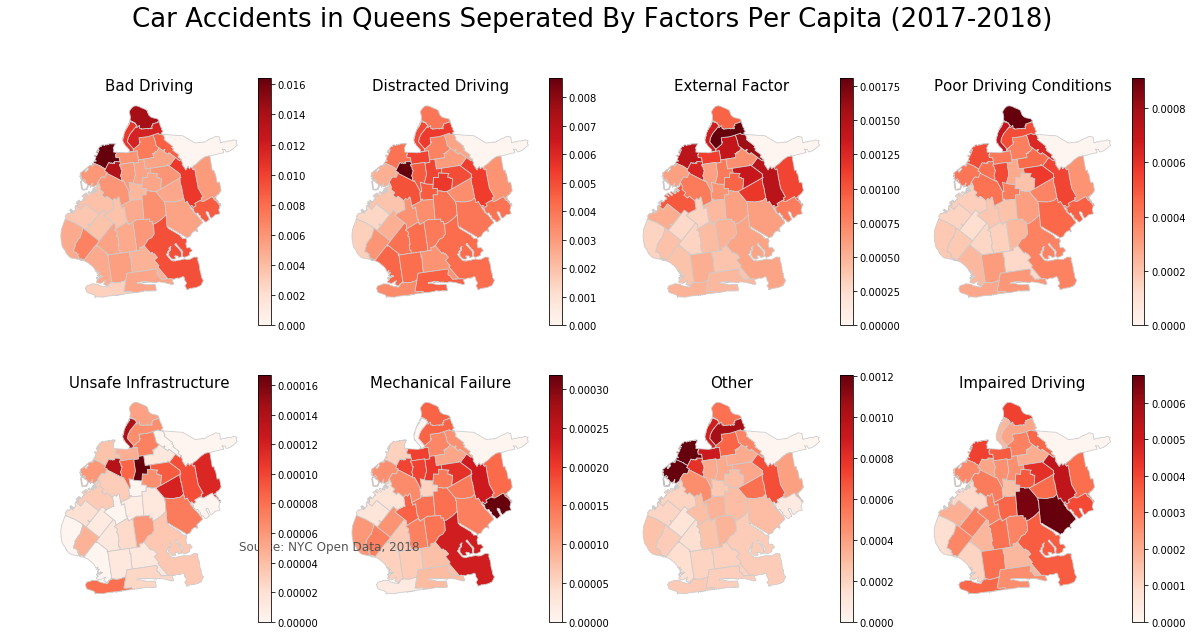

In [17]:
import matplotlib.pyplot as plt
# set a variable that will call whatever column we want to visualise on the map
#variable = "Distracted Driving"
var_list = ['Bad Driving Per Cap','Distracted Driving Per Cap', 'External Factor Per Cap',\
             'Poor Driving Conditions Per Cap','Unsafe Infrastructure Per Cap','Mechanical Failure Per Cap'\
             ,'Other Per Cap','Impaired Driving Per Cap']
title_list = ['Bad Driving','Distracted Driving','External Factor','Poor Driving Conditions'\
               ,'Unsafe Infrastructure','Mechanical Failure','Other','Impaired Driving']
# create figure and axes for Matplotlib
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
counter = 0
for row in range(0,2):
    for item in range(0,4):
        Brooklyn.plot(column=var_list[counter], cmap='Reds', linewidth=0.8, ax=ax[row, item], edgecolor='0.8')
        # set the range for the choropleth
        vmin, vmax = 0, float(max(Brooklyn[var_list[counter]]))
        ax[row, item].axis('off')
        ax[row, item].set_title(title_list[counter],fontsize=15)
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
        # empty array for the data range
        sm._A = []
        # add the colorbar to the figure
        cbar = fig.colorbar(sm,ax=ax[row, item])
        counter += 1

fig.suptitle("Car Accidents in Queens Seperated By Factors Per Capita (2017-2018)",fontsize=26)
# create an annotation for the data source
plt.annotate('Source: NYC Open Data, 2018',xy=(0.2, .15),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
plt.show()

In [18]:
total = Brooklyn.append(Bronx, ignore_index=True)
total = total.append(Manhattan, ignore_index=True)
total = total.append(Queens, ignore_index=True)
total = total.append(Staten_Island, ignore_index=True)
#Queens = Queens[Queens['POPULATION'] != 0]
#Staten_Island = df_groupall[df_groupall['BOROUGH'] == 'STATEN ISLAND']

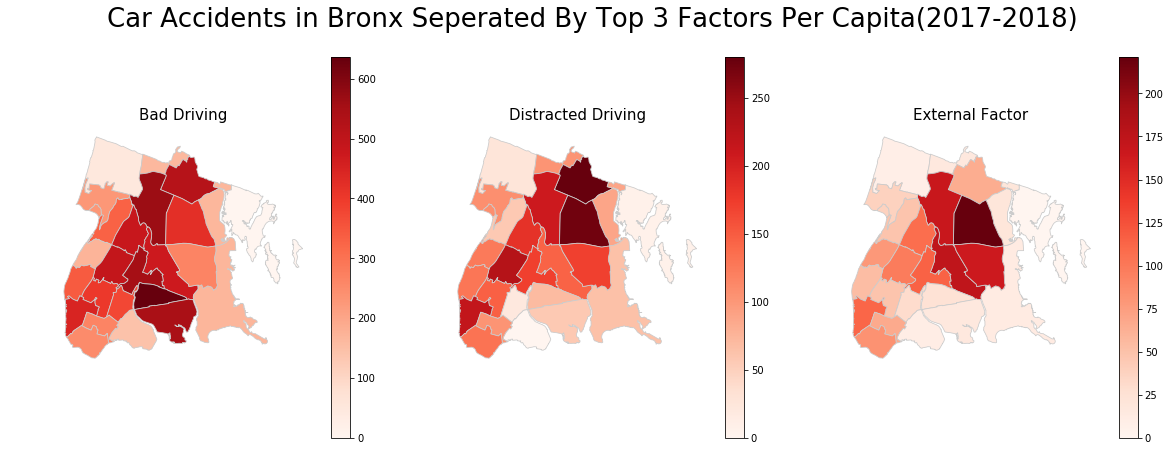

In [19]:
# set a variable that will call whatever column we want to visualise on the map
#variable = "Distracted Driving"
#var_list = ['Bad Driving Per Cap','Distracted Driving Per Cap', 'External Factor Per Cap']
var_list = ['Bad Driving','Distracted Driving', 'External Factor']#,\
             #'Poor Driving Conditions Per Cap','Unsafe Infrastructure Per Cap','Mechanical Failure Per Cap'\
             #,'Other Per Cap','Impaired Driving Per Cap']
title_list = ['Bad Driving','Distracted Driving','External Factor']#,'Poor Driving Conditions'\
               #,'Unsafe Infrastructure','Mechanical Failure','Other','Impaired Driving']
# create figure and axes for Matplotlib
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
counter = 0
for row in range(0,3):
    #for item in range(0,4):
    Bronx.plot(column=var_list[counter], cmap='Reds', linewidth=0.8, ax=ax[row], edgecolor='0.8')
    # set the range for the choropleth
    vmin, vmax = 0, float(max(Bronx[var_list[counter]]))
    ax[row].axis('off')
    ax[row].set_title(title_list[counter],fontsize=15)
    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm,ax=ax[row])
    counter += 1

fig.suptitle("Car Accidents in Bronx Seperated By Top 3 Factors Per Capita(2017-2018)",fontsize=26)
# create an annotation for the data source
#plt.annotate('Source: NYC Open Data, 2018',xy=(0.2, .15),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
plt.savefig('heatmap_Brooklyn')
plt.show()

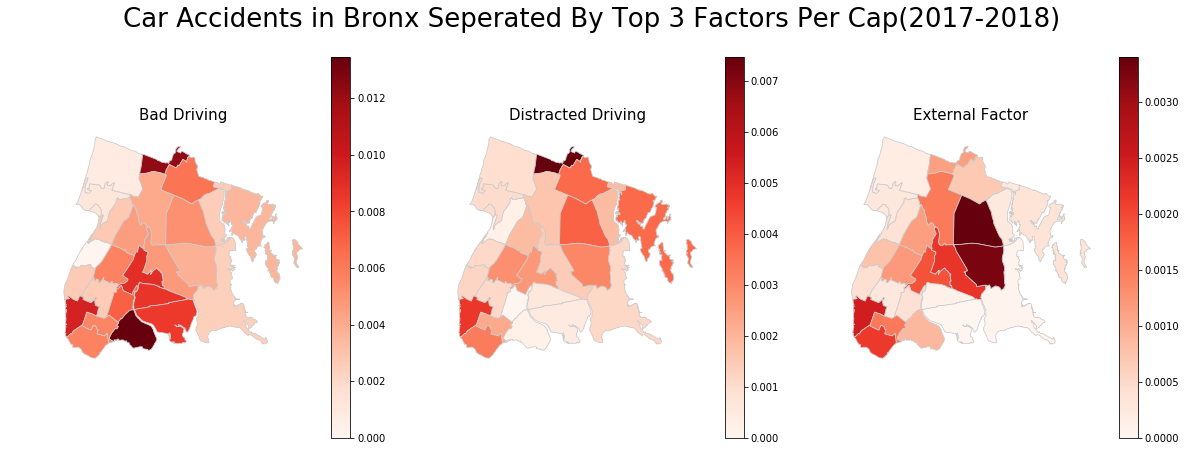

In [20]:
# set a variable that will call whatever column we want to visualise on the map
#variable = "Distracted Driving"
var_list = ['Bad Driving Per Cap','Distracted Driving Per Cap', 'External Factor Per Cap']
#var_list = ['Bad Driving','Distracted Driving', 'External Factor']#,\
             #'Poor Driving Conditions Per Cap','Unsafe Infrastructure Per Cap','Mechanical Failure Per Cap'\
             #,'Other Per Cap','Impaired Driving Per Cap']
title_list = ['Bad Driving','Distracted Driving','External Factor']#,'Poor Driving Conditions'\
               #,'Unsafe Infrastructure','Mechanical Failure','Other','Impaired Driving']
# create figure and axes for Matplotlib
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
counter = 0
for row in range(0,3):
    #for item in range(0,4):
    Bronx.plot(column=var_list[counter], cmap='Reds', linewidth=0.8, ax=ax[row], edgecolor='0.8')
    # set the range for the choropleth
    vmin, vmax = 0, float(max(Bronx[var_list[counter]]))
    ax[row].axis('off')
    ax[row].set_title(title_list[counter],fontsize=15)
    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm,ax=ax[row])
    counter += 1

fig.suptitle("Car Accidents in Bronx Seperated By Top 3 Factors Per Cap(2017-2018)",fontsize=26)
# create an annotation for the data source
#plt.annotate('Source: NYC Open Data, 2018',xy=(0.2, .15),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
plt.savefig('heatmap_Manhattan')
plt.show()

In [21]:
def top3zipcode(df, factor):
    result = df.sort_values(by=[factor],ascending = False).head(6)[['ZIPCODE', factor]]
    return result

In [22]:
#Manhattan[Manhattan['Bad Driving'] == max(Manhattan['Bad Driving'])]
#new_index = [1,2,3]
total_zipcode = top3zipcode(Manhattan, var_list[0]).reset_index().drop('index', axis = 1)
#total_zipcode['Rank'] = [1,2,3]
#total_zipcode = total_zipcode.set_index('Rank')
#total_zipcode = total_zipcode.append(top3zipcode(Brooklyn, 'Bad Driving Per Cap'))
#total_zipcode = total_zipcode.append(top3zipcode(Bronx, 'Bad Driving Per Cap'))
#total_zipcode = total_zipcode.append(top3zipcode(Queens, 'Bad Driving Per Cap'))
#total_zipcode = total_zipcode.append(top3zipcode(Staten_Island, 'Bad Driving Per Cap'))
#total_zipcode = total_zipcode.reset_index().drop('index', axis = 1)
total_zipcode.drop(df.index[[1,2,3]])

ZIPCODE  Bad Driving Per Cap
0    10018             0.114483
4    10004             0.042067
5    10001             0.036229

### BARGRAPH (Group by Borough) (Jason)

In [23]:
def groupby_borough(df):
    temp_df = df.groupby(['REASON','BOROUGH']).size().unstack().sort_values('REASON',ascending= True)#.head(3).T
    temp_df = temp_df/temp_df.sum(0)*100
    temp_df = temp_df.T
    return temp_df

In [24]:
#temp_df = df.groupby(['REASON','BOROUGH']).size().unstack().sort_values('REASON',ascending= True)#.head(3).T
#temp_df/temp_df.sum(0)*100

In [25]:
df_barh = groupby_borough(df)
df_barh.head()

REASON         Bad Driving  Distracted Driving  External Factor  \
BOROUGH                                                           
BRONX            56.382568           21.069546        11.826713   
BROOKLYN         51.844108           31.919898         6.262455   
MANHATTAN        47.905629           37.251656         7.657285   
QUEENS           52.028254           34.871439         4.597815   
STATEN ISLAND    51.449859           30.024164         6.443818   

REASON         Impaired Driving  Mechanical Failure     Other  \
BOROUGH                                                         
BRONX                  2.410336            1.066975  3.155933   
BROOKLYN               2.554637            1.048643  3.227598   
MANHATTAN              1.324503            0.513245  3.067053   
QUEENS                 2.425983            0.818563  2.158630   
STATEN ISLAND          3.000403            1.530407  2.356021   

REASON         Poor Driving Conditions  Unsafe Infrastructure  
BOROUGH                                                        
BRONX                         3.740841               0.347088  
BROOKLYN                      2.763712               0.378949  
MANHATTAN                     1.945364               0.335265  
QUEENS                        2.845166               0.254151  
STATEN ISLAND                 4.752316               0.443012

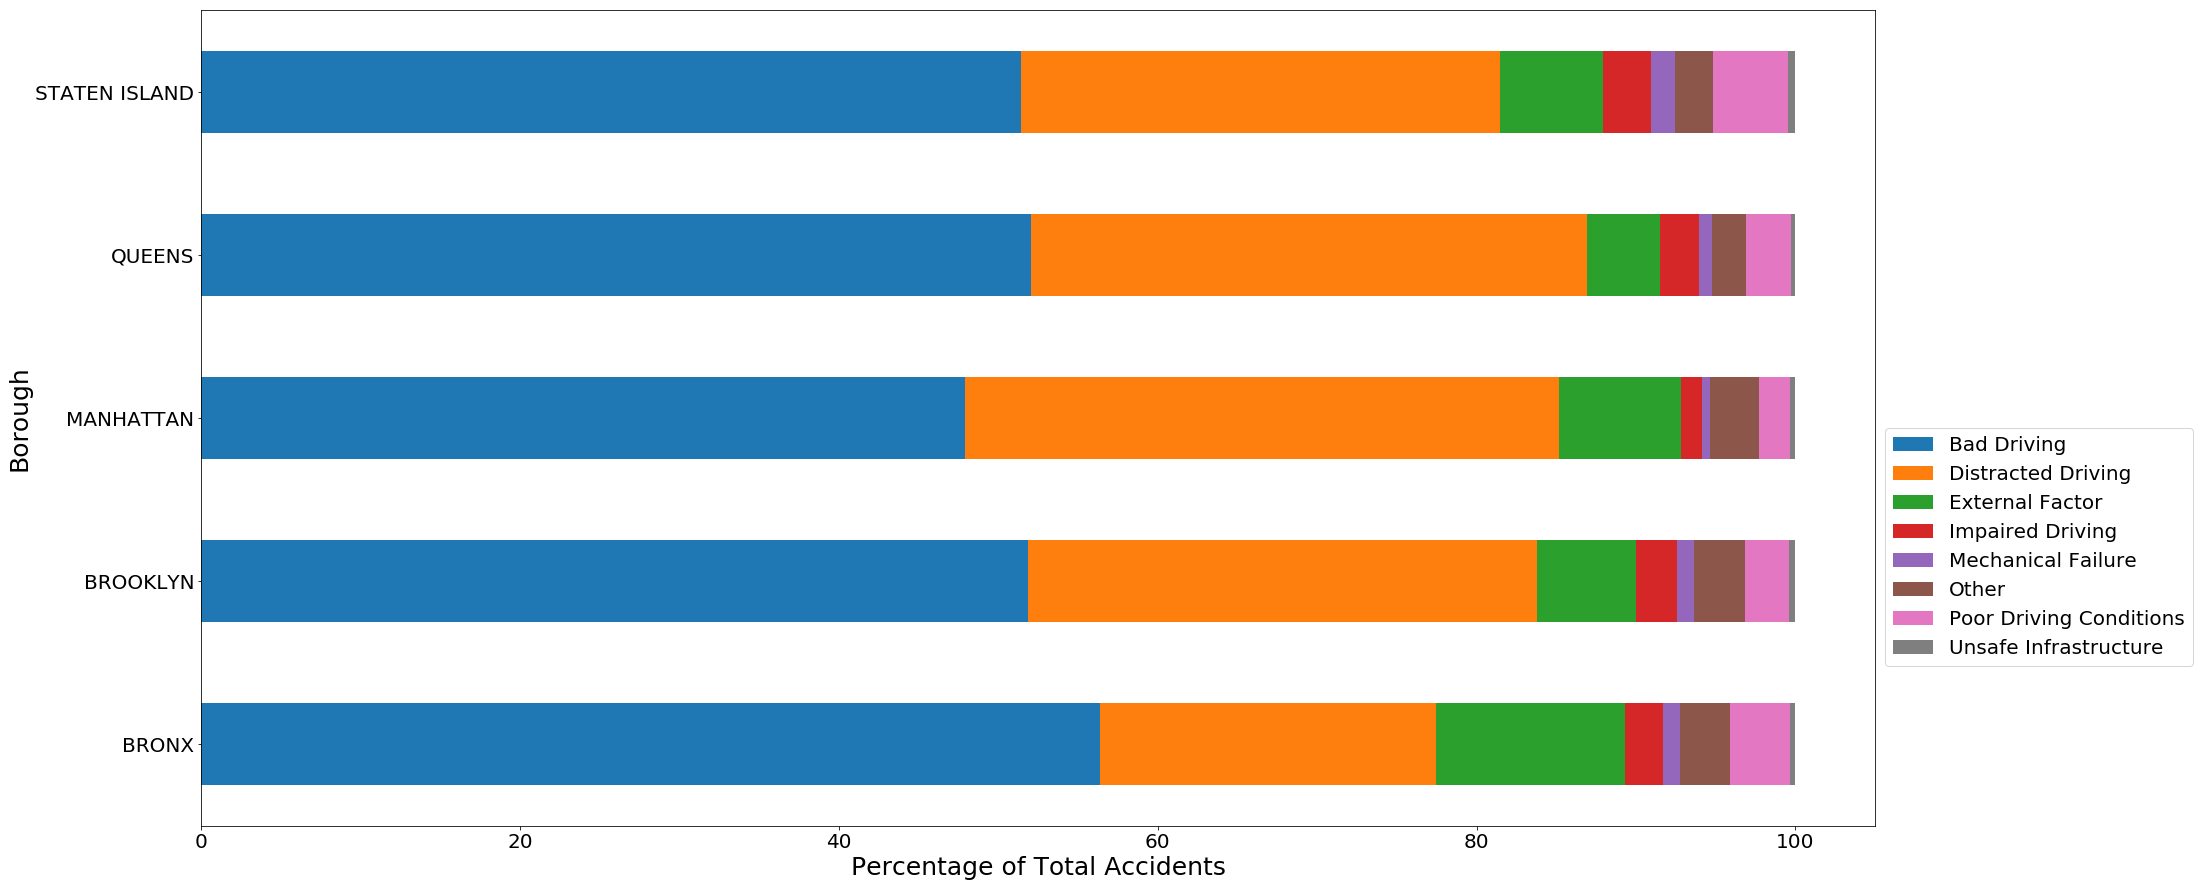

In [26]:
df_barh.plot(kind='barh', figsize=(30, 15),stacked=True)
plt.xlabel('Percentage of Total Accidents', fontsize=25)
plt.ylabel('Borough', fontsize=25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.legend(loc=0, prop={'size': 15})
plt.legend(loc=0,bbox_to_anchor=(1, 0.5),prop={'size': 20})
plt.savefig('stacked_his.pdf')
plt.show()